# Modeling Demand for Cars with the IPDL model

In this notebook, we will introduce and estimate the Inverse Product Differentiation Logit (IPDL) model of Fosgerau et al. (2023) using publically available data on the European car market from Frank Verboven's website at https://sites.google.com/site/frankverbo/data-and-software/data-set-on-the-european-car-market. We begin by introducing the data set. 


Data
====

The dataset consists of approximately 110 vehicle makes per year in the period 1970-1999 in five European markets (Belgium, France, Germany, Italy, and the United Kingdom). The data set includes 47 variables in total. The first four columns are market and product codes for the year, country, and make as well as quantity sold (No. of new registrations) which will be used in computing observed market shares. The remaining variables consist of car characteristics such as prices, horse power, weight and other physical car characteristics as well as macroeconomic variables such as GDP per capita which have been used to construct estimates of the average wage income and purchasing power.

We have in total 30 years and 5 countries, totalling $T=150$ year-country combinations, indexed by $t$, and we refer to each simply as market $t$. In market $t$, the choice set is $\mathcal{J}_t$ which includes the set of available makes as well as an outside option. Let $\mathcal{J} := \bigcup_{t=1}^T \mathcal{J}_t$ be the full choice set and 
 $J:=\#\mathcal{J}$ the number of choices which were available in at least one market, for this data set there are $J=357$ choices.
 


Reading in the dataset `eurocars.csv` we thus have a dataframe of $\sum_{t=1}^T \#\mathcal{J}_t = 11459$ rows and $47$ columns. The `ye` column runs through $y=70,\ldots,99$, the `ma` column runs through $m=1,\ldots,M$, and the ``co`` column takes values $j\in \mathcal{J}$. 

Because we consider a country-year pair as the level of observation, we construct a `market` column taking values $t=1,\ldots,T$. In Python, this variable will take values $t=0,\ldots,T-1$. We construct an outside option $j=0$ in each market $t$ by letting the 'sales' of $j=0$ be determined as 

$$\mathrm{sales}_{0t} = \mathrm{pop}_t - \sum_{j=1}^J \mathrm{sales}_{jt}$$

where $\mathrm{pop}_t$ is the total population in market $t$, and the car characteristics of the outside option is set to zero. The market shares of each product in market $t$ can then be found as
$$
\textrm{market share}_{jt}=\frac{\mathrm{sales_{jt}}}{\mathrm{pop}_t}.
$$
We also read in the variable description of the dataset contained in `eurocars.dta`. We will use the list `x_vars` throughout to work with our explanatory variables. 

In [5]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
import os
from numpy import linalg as la
from scipy import optimize
import scipy.stats as scstat
from matplotlib import pyplot as plt
import itertools as iter

# Files
import Logit_file as logit
import Eurocarsdata_file as eurocarsdata

   variable names                                        description
0              cy            cylinder volume or displacement (in cc)
1              hp                                 horsepower (in kW)
2              we                                     weight (in kg)
3              le                                     length (in cm)
4              wi                                      width (in cm)
5              he                                     height (in cm)
6              li          average of li1, li2, li3 (used in papers)
7              sp                            maximum speed (km/hour)
8              ac  time to acceleration (in seconds from 0 to 100...
9              pr   price (in destination currency including V.A.T.)
10          brand                                      name of brand
11           home  domestic car dummy (appropriate interaction of...
12            cla                              class or segment code
x has full rank


In [6]:
# Load dataset and variable names
# os.chdir('../GREENCAR_notebooks/') # Assigns work directory

input_path = os.getcwd() # Assigns input path as current working directory (cwd)
descr = (pd.read_stata('eurocars.dta', iterator = True)).variable_labels() # Obtain variable descriptions
dat_file = pd.read_csv(os.path.join(input_path, 'eurocars.csv')) # reads in the data set as a pandas dataframe.

In [7]:
pd.DataFrame(descr, index=['description']).transpose().reset_index().rename(columns={'index' : 'variable names'}) # Prints data sets

,variable names,description
0,ye,year (=first dimension of panel)
1,ma,market (=second dimension of panel)
2,co,model code (=third dimension of panel)
3,zcode,alternative model code (predecessors and succe...
4,brd,brand code
5,type,name of brand and model
6,brand,name of brand
7,model,name of model
8,org,"origin code (demand side, country with which c..."
9,loc,"location code (production side, country where ..."


In [8]:
# Outside option is included if OO == True, otherwise analysis is done on the inside options only.
OO = True

# Choose which variables to include in the analysis, and assign them either as discrete variables or continuous.

x_discretevars = [ 'brand', 'home', 'cla']
x_contvars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac', 'pr']
z_IV_contvars = ['xexr']
z_IV_discretevars = []
x_allvars =  [*x_contvars, *x_discretevars]
z_allvars = [*z_IV_contvars, *z_IV_discretevars]

if OO:
    nest_vars = [var for var in ['in_out', *x_allvars] if (var != 'pr')] # We nest over all variables other than price, but an alternative list can be specified here if desired.
else:
    nest_vars = [var for var in x_allvars if (var != 'pr')] # See above

nest_cont_vars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac'] # The list of continuous variables, from which nests will be created according to the deciles of the distribution.

G = len(nest_vars)

# Print list of chosen variables as a dataframe
pd.DataFrame(descr, index=['description'])[x_allvars].transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,cy,cylinder volume or displacement (in cc)
1,hp,horsepower (in kW)
2,we,weight (in kg)
3,le,length (in cm)
4,wi,width (in cm)
5,he,height (in cm)
6,li,"average of li1, li2, li3 (used in papers)"
7,sp,maximum speed (km/hour)
8,ac,time to acceleration (in seconds from 0 to 100...
9,pr,price (in destination currency including V.A.T.)


We now clean the data to fit our setup

In [9]:
dat, dat_org, x_vars, z_vars, N, pop_share, T, J, K = eurocarsdata.Eurocars_cleandata(dat_file, x_contvars, x_discretevars, z_IV_contvars, z_IV_discretevars, outside_option=OO)

In [10]:
# Create dictionaries of numpy arrays for each market. This allows the size of the data set to vary over markets.

dat = dat.reset_index(drop = True).sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull

x = {t: dat[dat['market'] == t][x_vars].values.reshape((J[t],K)) for t in np.arange(T)} # Dict of explanatory variables
y = {t: dat[dat['market'] == t]['ms'].to_numpy().reshape((J[t])) for t in np.arange(T)} # Dict of market shares

In [11]:
# This function tests whether the utility parameters are identified, by looking at the rank of the stacked matrix of explanatory variables.

def rank_test(x):
    x_stacked = np.concatenate([x[t] for t in np.arange(T)], axis = 0)
    eigs=la.eig(x_stacked.T@x_stacked)[0]

    if np.min(eigs)<1.0e-8:
        print('x does not have full rank')
    else:
        print('x has full rank')

In [12]:
rank_test(x)

x has full rank


## Perturbed utility, logit and nested logit

In the following, a vector $z\in \mathbb R^d$ is always a column vector. The IPDL model is a discrete choice model, where the probability vector over the alternatives is given by the solution to a utility maximization problem of the form
$$
p=\arg\max_{q\in \Delta} q'u-\Omega(q)
$$
where $\Delta$ is the probability simplex over the set of discrete choices, $u$ is a vector of payoffs for each option, $\Omega$ is a convex function and $q'$ denotes the transpose of $q$. All additive random utility models can be represented in this way (Fosgerau and Sørensen (2021)). For example, the logit choice probabilities result from the perturbation function $\Omega(q)=q'\ln q$ where $\ln q$ is the elementwise logarithm.

In the nested logit model, the choice set is divided into a partition $\mathcal C=\left\{C_1,\ldots,C_L\right\}$, and the perturbation function is given by
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \sum_{\ell =1}^L \left( \sum_{j\in C_\ell}q_j\right)\ln \left( \sum_{j\in C}q_j\right),
$$
where $\lambda\in [0,1)$ is a parameter. This function can be written equivalently as
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \left(\psi q\right)'\ln \left( \psi q\right),
$$
where $\psi$ is a $J \times L$ matrix, where $\psi_{j\ell}=1$ if option $j$ belongs to nest $C_\ell$ and zero otherwise.
 This specification generates nested logit choice probabilities.


## The IPDL model

In the IPDL model, we allow for multiple nesting structures. For each $g=1,\ldots, G$, let $\mathcal C_g$ and $\psi^g$ be constructed as described for the nested logit, and let $L_g$ be the number of nests in group $g$. The IPDL perturbation function is then
$$
\Omega(q|\lambda)=(1-\sum_g \lambda_g) q'\ln q +\sum_g \lambda_g \left(\psi^g q \right)'\ln \left( \psi^g q\right),
$$
where $\lambda=(\lambda_1,\ldots,\lambda_G)$ is a parameter vector satisfying $\lambda_g \geq 0$ and $\sum_g \lambda_g<1$. In this model, each option belongs to $G\geq 1$ nests. When $G=1$, it simplifies to the nested logit model, and when $\sum_g \lambda_g=0$, it simplifies to the logit model. The IPDL model therefore allows more flexibility than a single nested logit model in the types of substitution patterns it can represent, without having to specify a hierarchical structure over the nests.

In this note, the nesting is done according to a subset of the explanatory variables. For categorical variables, each category is a nest. For continuous variables, the data set is partitioned according to the deciles of the variable, resulting in `at most` 10 nests of roughly equal size, as well as a nest for the outside option. This construction implies that $\Omega$ is a function of the data.

## Similarity and negative values of $\lambda$

Bla bla bla


## The utility function

Let $x_{tj}$ be the vector of product characteristics for option $j$ in market $t$, and let $X_t$ denote the $J_t\times K $ matrix with elements $x_{tjk}$. The payoff of option $j$ is a linear function of the characteristics $x_{tj}$ of product $j$, which means that the vector of utilities may be written
$$
u(X_t,\beta)=X_t\beta.
$$

Letting $\theta=(\beta',\lambda')'$ denote the full parameter vector of length $D=K+G$, the choice probabilities in market $t$ may be written as
$$
p_t(\theta)=\arg \max_{q\in \Delta_{J_t}} \left\{q'X_t \beta-(1-\sum_g \lambda_g)q'\ln q +\sum_{g=1}^G\lambda_g \left(\psi^{gt} q \right)'\ln \left(\psi^{gt} q\right)\right\}
$$



# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

The gradient of $\Omega$ with respect to the choice probabilities is

$$
\nabla_q \Omega_t(q|\lambda)=(1-\sum_g \lambda_g)\ln q+ \sum_g \lambda_g(\psi^{gt})'\ln \left( \psi^{gt}q\right)+\iota=\ln q-Z_t(q)\lambda+\iota
$$
where $\iota$ is the all-ones vector and
$$Z_{tg}(q)=\ln q - (\psi^{tg})' \ln (\psi^{tg}q)$$

The Hessian of $\Omega$ is
$$
\nabla_{qq}^2 \Omega_t(q|\lambda)=(1-\sum_g \lambda_g) \mathrm{diag}(q)^{-1}+\sum_g\lambda_g (\psi^{gt})'\mathrm{diag}(\psi^{gt}q)^{-1}\psi^{gt}
$$

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.














For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

In [13]:
def Create_nests(data, markets_id, products_id, columns, cont_var = None, cont_var_bins = None, outside_option = True):
    '''
    This function creates the nest matrices \Psi^{gt}, and stack them over g for each t.

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        columns: a list containing the column names of columns in 'data' from which nest groupings g=0,1,...,G-1 for each market t are to be generated
        cont_var: a list of the continuous variables in 'columns'
        cont_var_bins: a list containing the number of bins to make for each continuous variable in 'columns'
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns
        Psi: a dictionary of length T of the J[t] by J[t] identity stacked on top of the Psi_g matrices for each market t and each gropuing g
        nest_dict: a dictionary of length T of pandas series describing the structure of each nest for each market t and each grouping g
        nest_count: a dictionary of length T of (G,) numpy arrays containing the amount of nests in each category g
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    
    # We include nest on outside vs. inside options. The amount of categories varies if the outside option is included in the analysis.
    dat = data.sort_values(by = [markets_id, products_id]) # We sort the data in ascending, first according to market and then according to the product id
    
    Psi = {}
    nest_dict = {}
    nest_counts = {}

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t] # Subset data on market t


        ### Bin continuous variables according to quantiles of the variable

        if cont_var == None:
            None
        else:
            for var,n_bins in zip(cont_var,cont_var_bins):
                if outside_option:
                    q_dat = np.unique(np.quantile(data_t[var].rank(method = 'min'), q = np.arange(1,n_bins + 1) / n_bins)) # Get the unique 'n_bins' equally spaced quantiles of each continuous variable given in the cont_var list
                    data_t[var] = pd.cut(data_t[var].rank(method = 'min'), bins = [0.99,1, *q_dat], labels=False) # Quantiles are equally spaced with 'n_bins' quantiles for the variable. The outside option gets its own bin (0.99,1].
                else:
                    q_dat = np.unique(np.quantile(data_t[var].rank(method = 'min'), q = np.arange(1,n_bins + 1) / n_bins)) # Get the unique 'n_bins' equally spaced quantiles of each continuous variable given in the cont_var list
                    data_t[var] = pd.cut(data_t[var].rank(method = 'min'), bins = q_dat, labels=False) # Bin the variable according to 'n_bins' equally spaced quantiles.

        nest_dict[t] = data_t[columns].apply(lambda col: list(np.unique(col))) # Get the unique values of each 'col' in columns
        nest_counts[t] = data_t[columns].nunique().values # Find the number of unique values in each column in columns and output as a numpy array

        nest_count_total = data_t[columns].nunique().sum() # Find the sum of nest counts L_g
        nests = pd.get_dummies(data_t[columns], columns = columns).values.reshape((J[t], nest_count_total)).transpose() # Finds dummies for each category in columns, and converts these to numpy arrays of the appropiate size. Note that the data has been sorted according to market and then product.
        Psi_t = np.concatenate([np.eye(J[t]), nests], axis = 0) # Stack a J[t] by J[t] identity on top of the stacked \Psi^g matrices for each market t

        Psi[t] = Psi_t

    return Psi, nest_dict, nest_counts

In [14]:
cont_bins=[np.int64(10) for i in range(len(nest_cont_vars))] # Sets the number of bins to 10 for each continuous variable.
Psi, Nest_descr, Nest_count = Create_nests(dat, 'market', 'co', nest_vars, nest_cont_vars, cont_bins , outside_option=OO)

In [15]:
def Create_Gamma(Lambda, Psi, nest_count):
    '''
    This function 
    '''

    T = len(Psi)
    
    Gamma = {}
    lambda0 = np.array([1 - sum(Lambda)])
    Lambda_full = np.concatenate((lambda0, Lambda)) # create vector (1- sum(lambda), lambda_1, ..., lambda_G)

    for t in np.arange(T):
        C,J = Psi[t].shape # The amount of alternatives in market t
        Lambda_long = np.empty((C,)) # Initialize a row vector with as many rows as psi_stack
        indices = np.concatenate((np.array([J]) , nest_count[t])).cumsum().astype('int64') # Get the indices of where the identity and the nests in psi_stack are located along the rows of psi_stack.

        for i in np.arange(len(indices)):
            if i == 0:
                Lambda_long[0:(indices[i])] = Lambda_full[i] # Assign 1-sum(lambda) to the first J coordinates of Lambda_long
            else:
                Lambda_long[indices[i-1]:indices[i]] = Lambda_full[i] # Assign lambda_g to the coordinates of Lambda_long corresponding to the rows of psi_stack equal to the block matrix \psi^g 
    
        Gamma[t] =  np.einsum('c,cj->cj', Lambda_long, Psi[t]) # Compute hadamard product of lambda parameters and psi_stack

    return Gamma

In [16]:
lambda0 = np.ones((G,))/(2*(G+1))
Gamma0 = Create_Gamma(lambda0, Psi, Nest_count)

## Model solution

Suppose we are evaluating the choice probability function $p_t(\theta)$ at some parameter vector $\theta$. While it is possible to solve for the choice probabilities explicitly by numerical maximization, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Let $u_t=X_t\beta$ and let $q_t^0$ be an initial guess of the choice probabilities, e.g. $q_t^0\propto \exp(X_t\beta)$. Define further
$$
a=\sum_{g:\lambda_g\geq 0} \lambda_g   \qquad b=\sum_{g:\lambda_g<0} |\lambda_g|.
$$

The choice probabilities are then updated iteratively as
$$
q_t^{r} = \frac{e^{v_t^{r}}}{\sum_{j\in \mathcal J_t} e^{v_{tj}^{r}}},
$$
where
$$
v_t^{r} =\ln q_t^{r-1}+\left(u_t-\nabla_q \Omega_t(q^{r-1}_t|\lambda)\right)/(1+b).
$$
Using the definition of $Z_{gt}$ above, this becomes
$$
v^r_t=\ln q_t^{r-1}+\left(u_t+Z_{t}(q^{r-1})\lambda-\ln q_t^{r-1}  \right)/(1+b) =  \left( u_t+ b\ln q^{r-1}_t+Z_{t}(q^{r-1})\lambda\right)/(1+b)
$$


For numerical stability, it can be a good idea to also do max-rescaling of $v^r_t$ at every iteration. The Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p_t(\theta)||q_t^{r})\leq \frac{a+b}{1+b}D_{KL}(p_t(\theta)||q^{r-1}_t).
$$
This is implemeneted in the function "IPDL_ccp" below. 

In [17]:
def IPDL_ccp(Theta, x, psi, nest_count, tol = 1.0e-15, maximum_iterations = 1000):
    '''
    This function finds approximations to the true conditional choice probabilities given parameters.

    Args.
        Theta: a numpy array (K+G,) of parameters
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        tol: tolerated approximation error
        maximum_iterations: a no. of maximum iterations which if reached will stop the algorithm

    Output
        q_1: a dictionary of T numpy arrays (J[t],) of IPDL choice probabilities for each market t
    '''

    T = len(x) # Number of markets
    K = x[0].shape[1] # Number of car characteristics

    # Parameters
    Beta = Theta[:K]
    Lambda = Theta[K:]
    G = len(Lambda)  # Number of groups

    #print(Lambda)
    # Calculate small beta
    C_minus = np.array([True if Lambda[g] < 0 else False for g in np.arange(G)])
    #print(C_minus) # Find the categories g with negative a negative parameter lambda_g
    if C_minus.all() == False:
        b = 0
    else:    
        b = np.abs(Lambda[C_minus]).sum() # sum of absolute value of negative lambda parameters.

    Gamma = Create_Gamma(Lambda, psi, nest_count) # Find the Gamma matrix

    u = {t: np.einsum('jk,k->j', x[t], Beta) for t in np.arange(T)} # Calculate linear utilities
    q = {t: np.exp(u[t]) / np.exp(u[t]).sum() for t in np.arange(T)}
    q0 = q
    Epsilon = 1.0e-10

    for k in range(maximum_iterations):
        q1 = {}
        for t in np.arange(T):
            # Calculate v
            psi_q = np.einsum('cj,j->c', psi[t], q0[t]) # Compute matrix product
            log_psiq =  np.log(np.abs(psi_q) + Epsilon) # Add Epsilon? to avoid zeros in log np.log(np.abs(gamma_q), out = np.NINF*np.ones_like(gamma_q), where = (np.abs(gamma_q) > 0))
            gamma_log_prod = np.einsum('cj,c->j', Gamma[t], log_psiq) # Compute matrix product
            v = np.log(q0[t] + Epsilon) + (u[t] - gamma_log_prod)/(1 + b) # Calculate v = log(q) + (u - Gamma^T %o% log(Gamma %o% q) %o% Gamma)/(1 + b)
            v -= v.max(keepdims = True) # Do max rescaling wrt. alternatives

            # Calculate iterated ccp q^k
            numerator = np.exp(v)
            denom = numerator.sum()
            q1[t] = numerator/denom

        # Check convergence in an appropriate distance function
        dist = np.max(np.array([np.sum((q1[t]-q0[t])**2/q[t]) for t in np.arange(T)])) # Uses logit weights. This avoids precision issues when q1~q0~0.
        
        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None
            
        # Iteration step
        q0 = q1

    return q1 

## Demand derivatives and price Elasticity

While the demand derivatives in the IPDL model are not quite as simple as in the logit model, they are still easy to compute. 
Let $q=P(u|\lambda)$, then
$$
\nabla_u P(u|\lambda)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse. The derivatives with respect to any $x_{ij\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\lambda)=\mathrm{diag}(P(u|\lambda))^{-1}\nabla_u P(u|\lambda).
$$

In [18]:
def compute_pertubation_hessian(q, x, Theta, psi, nest_count):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Hess: a dictionary of T numpy arrays (J[t],J[t]) of second partial derivatives of the pertubation function \Omega for each market t
    '''
    
    T = len(q.keys())
    K = x[0].shape[1]

    Gamma = Create_Gamma(Theta[K:], psi, nest_count) # Find the \Gamma matrices 
    #Hess = {}
    Hess={}
    for t in np.arange(T):
        psi_q = np.einsum('cj,j->c', psi[t], q[t]) # Compute a matrix product
        Hess[t] = np.einsum('cj,c,cl->jl', Gamma[t], 1/psi_q, psi[t]) # Computes the product \Gamma' diag(\psi q)^{-1} \psi (but faster)

    return Hess

In [19]:
def ccp_gradient(q, x, Theta, psi_stack, nest_count):
    
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K) of partial derivatives of the choice proabilities wrt. utilities for each market t
    '''

    T = len(q.keys())
    Grad = {}
    Hess = compute_pertubation_hessian(q, x, Theta, psi_stack, nest_count) # Compute the hessian of the pertubation function

    for t in np.arange(T):
        inv_omega_hess = la.inv(Hess[t]) # (J,J) for each t=1,...,T , computes the inverse of the Hessian
        qqT = q[t][:,None]*q[t][None,:] # (J,J) outerproduct of ccp's for each market t
        Grad[t] = inv_omega_hess - qqT  # Compute IPDL gradient of ccp's wrt. utilities

    return Grad

In [20]:
def IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the gradient of the log choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Epsilon: a dictionary of T numpy arrays (J[t],J[t]) of partial derivatives of the log choice proabilities of products j wrt. utilites of products k for each market t
    '''

    T = len(q.keys())
    Epsilon = {}
    Grad = ccp_gradient(q, x, Theta, psi_stack, nest_count) # Find the gradient of ccp's wrt. utilities
    
    for t in np.arange(T):
        #ccp_grad = Grad[t]
        #inv_diagq = np.divide(1, q[t], out = np.inf*np.ones_like(q[t]), where = (q[t] > 0)) # Find the inverse of the ccp's and assign infinity to any entry if that entry has q = 0
        Epsilon[t] = Grad[t]/q[t][:,None] # Computes diag(q)^{-1}Grad[t]
        #np.einsum('j,jk->jk', inv_diagq, ccp_grad) # Computes a Hadamard product. Is equivalent to:   diag(q)^-1 %o% ccp_grad

    return Epsilon

In [21]:
def IPDL_elasticity(q, x, Theta, psi_stack, nest_count, char_number = K-1):
    ''' 
    This function calculates the elasticity of choice probabilities wrt. any characteristic or nest grouping of products

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        char_number: an integer which is an index of the parameter in theta wrt. which we wish calculate the elasticity. Default is the index for the parameter of 'pr'.

    Returns
        a dictionary of T numpy arrays (J[t],J[t]) of choice probability semi-elasticities for each market t
    '''
    T = len(q.keys())
    Epsilon = {}
    Grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count) # Find the gradient of log ccp's wrt. utilities

    for t in np.arange(T):
        Epsilon[t] = Grad[t]*Theta[char_number] # Calculate semi-elasticities

    return Epsilon

## Maximum likelihood estimation of IPDL

The log-likelihood contribution is
$$
\ell_t(\theta)=y_t'\ln p(\mathbf{X}_t,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_t$ and $\theta$ - calculates $u_t=\mathbf{X}_t\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_t,\theta)$, and we can then evaluate $\ell_t(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

For maximizing the likelihood, we want the derivates at some $\theta=(\beta',\lambda')$. Let $q_t=p(\mathbf{X}_t,\theta)$, then we have
$$
\nabla_\theta \ln p(\mathbf{X}_t,\theta)=\mathrm{diag}(q_t)^{-1}\left(\nabla_{qq}^2\Omega(q_t|\lambda)^{-1}-q_tq_t' \right)\left[\mathbf{X}_t,-\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P(u|\lambda)$ and the last term is a block matrix of size $J\times dim(\theta)$. Note that the latter cross derivative $\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)$ is given by $\nabla_{q,\lambda} \Omega(q_t|\lambda)_g = \ln(q) - (\Psi^g)' \ln(\Psi^g q)$ for each row $g=1,\ldots,G$. The derivative of the log-likelihood function can be obtained from this as
$$
\nabla_\theta \ell_t(\theta)=\nabla_\theta \ln p(\mathbf{X}_t,\theta)' y_t \\
$$

In [22]:
def IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Output
        ll: a numpy array (T,) of IPDL loglikelihood contributions
    '''

    T = len(x.keys())
    K = x[0].shape[1]
    ccp_hat = IPDL_ccp(Theta, x, psi_stack, nest_count)
    sum_lambdaplus = np.array([theta for theta in Theta[K:] if theta >0]).sum()

    '''if sum_lambdaplus >= 1:
        ll = np.NINF*np.ones((T,))'''

    
    ll=np.empty((T,))
    for t in np.arange(T):
        ll[t] = sample_share[t]*(y[t].T@np.log(ccp_hat[t]))#np.einsum('j,j', y[t], np.log(ccp_hat[t], out = -np.inf*np.ones_like(ccp_hat[t]), where = (ccp_hat[t] > 0)))

    print([sum_lambdaplus, -ll.mean()])

    return ll

In [23]:
def q_IPDL(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' The negative loglikelihood criterion to minimize
    '''
    Q = -IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count)
    
    return Q

We also implement the derivative of the loglikehood wrt. parameters $\nabla_\theta \ell_t(\theta)$.

In [24]:
def cross_grad_pertubation(q, psi_stack, nest_count):
    ''' 
    This function calculates the cross diffential of the pertubation function \Omega wrt. first ccp's and then the lambda parameters

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Z: a dictionary of T numpy arrays (J[t],G) of cross diffentials of the pertubation function \Omega wrt. first ccp's and then the lambda parameters
    '''

    T = len(q.keys())
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0)) for t in np.arange(T)} # Determine log(q), and set entries equal minus inifinity if entry <= 0
    Z = {}
    
    for t in np.arange(T):
        G = len(nest_count[t])
        indices = np.int64(np.cumsum(nest_count[t])) # Find the indices of the categories g used in the psi_stack matrices
        J = np.int64(psi_stack[t].shape[0] - np.sum(nest_count[t])) # Find the number of alternatives
        Z_t = np.empty((J,G)) # Initialize a J[t] by G numpy matrix for market t

        for g in np.arange(G):

            # Find the \psi^g matrix for category g
            if g == 0:
                Psi = psi_stack[t][J:J+indices[g],:] 
            else:
                Psi = psi_stack[t][J+indices[g-1]:J+indices[g],:]

            Psi_q = np.einsum('cj,j->c', Psi, q[t]) # Compute a matrix product
            log_Psiq = np.log(Psi_q, out = -np.inf*np.ones_like(Psi_q), where = (Psi_q > 0)) # Determine log of Psi_q, and set entries equal to minus infinity if entry <= 0.
            Psi_logPsiq = np.einsum('cj,c->j', Psi, log_Psiq) # Compute matrix product

            Z_t[:,g] = log_q[t] - Psi_logPsiq # Compute cross differential
        
        Z[t] = Z_t
    
    return Z

In [25]:
def IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count):
    '''
    This function calculates the derivative of the IPDL log ccp's wrt. parameters theta

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K+G) of derivatives of the IPDL log ccp's wrt. parameters theta for each market t
    '''

    T = len(x.keys())

    q = IPDL_ccp(Theta, x, psi_stack, nest_count) # Find choice probabilities

    Z = cross_grad_pertubation(q, psi_stack, nest_count) # Find cross differentials of the pertubation function
    u_grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count)  # Find the gradient of log ccp's wrt. utilities
    Grad={}

    for t in range(T):
        G=np.concatenate((x[t], Z[t]), axis=1)
        Grad[t]=u_grad[t]@G
   
   # G = [np.concatenate((x[t], Z[t]), axis=1) for t in np.arange(T)] # Construct the block matrix of the covariates and the cross differentials as block matrices
    #Grad = {t: np.einsum('jk,kd->jd', u_grad[t], G[t]) for t in np.arange(T)} # Compute the derivative by matrix multiplication.

    return Grad

In [26]:
def IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count):
    '''
    This function calculates the score of the IPDL loglikelihood.

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        Score: a numpy array (T,K+G) of IPDL scores
    '''
    T = len(x.keys())

    log_ccp_grad = IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count) # Find derivatives of the IPDL log ccp's wrt. parameters theta
    D = log_ccp_grad[0].shape[1] # equal to K+G
    Score = np.empty((T,D))
    
    for t in np.arange(T):
        Score[t,:] =sample_share[t]*(log_ccp_grad[t].T@y[t]) #np.einsum('j,jd->d', y[t], log_ccp_grad[t]) # Computes a matrix product

    return Score

In [27]:
def q_IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' The derivative of the negative loglikelihood criterion
    '''
    return -IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count)

In [28]:
def test_analyticgrad(y, x, theta, sample_share, Psi, Nest_count, delta = 1.0e-8):

    numgrad = np.empty((T, K+G))

    for i in np.arange(K+G):
        vec = np.zeros((K+G,))
        vec[i] = 1
        numgrad[:,i] = (IPDL_loglikelihood(theta + delta*vec, y, x, sample_share, Psi, Nest_count) - IPDL_loglikelihood(theta, y, x, sample_share, Psi, Nest_count)) / delta

    angrad = IPDL_score(theta, y, x, sample_share, Psi, Nest_count)

    normdiff = la.norm(angrad - numgrad)
    
    return normdiff

In [29]:
theta0 = np.ones((K+G,))/(K+G)
test_analyticgrad(y, x, theta0, pop_share, Psi, Nest_count)

[0.2, 0.02532802581592098]
[0.2, 0.025328025752644607]
[0.2, 0.025328025773423423]
[0.2, 0.025328025752644607]
[0.2, 0.0253280257742625]
[0.2, 0.025328025752644607]


[0.2, 0.025328025785555663]
[0.2, 0.025328025752644607]
[0.2, 0.025328025804910493]
[0.2, 0.025328025752644607]
[0.2, 0.025328025808185297]
[0.2, 0.025328025752644607]
[0.2, 0.025328025807773717]
[0.2, 0.025328025752644607]
[0.2, 0.025328025781644066]
[0.2, 0.025328025752644607]
[0.2, 0.025328025793748807]
[0.2, 0.025328025752644607]
[0.2, 0.025328025772319317]
[0.2, 0.025328025752644607]
[0.2, 0.02532802575448933]
[0.2, 0.025328025752644607]
[0.2, 0.025328025752663914]
[0.2, 0.025328025752644607]
[0.2, 0.02532802575692615]
[0.2, 0.025328025752644607]
[0.2, 0.025328025754346756]
[0.2, 0.025328025752644607]
[0.2, 0.025328025755706987]
[0.2, 0.025328025752644607]
[0.2, 0.025328025756416794]
[0.2, 0.025328025752644607]
[0.2, 0.025328025752998543]
[0.2, 0.025328025752644607]
[0.2, 0.025328025752940065]
[0.2, 0.025328025752644607]
[0.2, 0.025328025753080664]
[0.2, 0.025328025752644607]
[0.2, 0.02532802575848033]
[0.2, 0.025328025752644607]
[0.2, 0.02532802575708758]
[0.2, 0.0253280257526446

1.265717055373921e-07

## Standard errors in Maximum Likelihood estimation

As usual we may consistently estimate the Covariance Matrix  of the IPDL maximum likelihood estimator for some estimate $\hat \theta = (\hat \beta', \hat \lambda')'\in \mathbb{R}^{K+G}$ as:

$$
\hat \Sigma = \left( \sum_{i=1}^N \nabla_\theta \ell_i (\hat \theta) \nabla_\theta \ell_i (\hat \theta)' \right)^{-1}
$$

Thereby we may find the estimated standard error of parameter $d$ as the squareroot of the d'th diagonal entry of $\hat \Sigma$:

$$
\hat \sigma_d = \sqrt{\hat \Sigma_{dd}}
$$

In [30]:
def IPDL_se(score, N):
    '''
    This function computes the asymptotic standard errors of the MLE.

    Args.
        score: a numpy array (T,K+G) of IPDL scores
        N: an integer giving the number of observations

    Returns
        SE: a numpy array (K+G,) of asymptotic IPDL MLE standard errors
    '''

    SE = np.sqrt(np.diag(la.inv(np.einsum('td,tm->dm', score, score))) / N)

    return SE

In [31]:
def IPDL_t_p(SE, Theta, N, Theta_hypothesis = 0):
    ''' 
    This function calculates t statistics and p values for characteristic and nest grouping parameters

    Args.
        SE: a numpy array (K+G,) of asymptotic IPDL MLE standard errors
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        N: an integer giving the number of observations
        Theta_hypothesis: a (K+G,) array or integer of parameter values to test in t-test. Default value is 0.
    
    Returns
        T: a (K+G,) array of estimated t tests
        p: a (K+G,) array of estimated asymptotic p values computed using the above t-tests
    '''

    T = np.abs(Theta - Theta_hypothesis) / SE
    p = 2*scstat.t.sf(T, df = N-1)

    return T,p

### We now estimate the model

In [32]:
def estimate_IPDL(f, Theta0, y, x, sample_share, psi_stack, nest_count, N, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given starting values and variables necessary in the IPDL model specification.

    Args:
        f: a function to minimize,
        Theta0 : a numpy array (K+G,) of initial guess parameters (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests', 
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t,
        N: an integer giving the number of observations,
        Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the IPDL loglikelihood function is used in estimation. Else the numerical jacobian is used.
        options: dictionary with options for the optimizer (e.g. disp=True which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, y, x, sample_share, psi_stack, nest_count))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.
    se = IPDL_se(IPDL_score(result.x, y, x, sample_share, psi_stack, nest_count), N)
    T,p = IPDL_t_p(se, result.x, N)

    # collect output in a dict 
    res = {
        'theta': result.x,
        'se': se,
        't': T,
        'p': p,
        'success':  result.success, # bool, whether convergence was succesful 1
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

In [33]:
beta_0 = np.ones((K,))

# Estimate the model
Logit_beta = logit.estimate_logit(logit.q_logit, beta_0, y, x, sample_share=pop_share, Analytic_jac=True)['beta']
Logit_SE = logit.logit_se(logit.logit_score(Logit_beta, y, x, pop_share), N)
Logit_t, Logit_p = logit.logit_t_p(Logit_beta, logit.logit_score(Logit_beta, y, x, pop_share), N)

# Initialize \theta^0
theta0 = np.append(Logit_beta,lambda0)

Optimization terminated successfully.
         Current function value: 0.001529
         Iterations: 26
         Function evaluations: 34
         Gradient evaluations: 34


In [34]:
resbla2 = estimate_IPDL(q_IPDL, theta0, y, x, pop_share, Psi, Nest_count, N, Analytic_jac=True)

[0.4642857142857142, 0.0015948261527286335]
[0.46079084676294746, 0.0015937636986622294]
[0.4468113766718806, 0.0015896014134653246]
[0.39089349630761283, 0.0015743076291167553]
[0.2281243669677471, 0.0015417555205683043]
[0.060600342124995175, 0.0015297514814028087]
[0.09194301569734192, 0.001528945875853086]
[0.08754792352009409, 0.0015289219523688684]
[0.08723707804525717, 0.001528921024770911]
[0.08688372100505572, 0.0015289192371360878]
[0.08547029284424992, 0.0015289138110982522]
[0.08332761495059388, 0.0015289014132569831]
[0.0805135351421179, 0.0015288788144729574]
[0.07629566513484756, 0.0015288368116710463]
[0.06989057552662799, 0.0015287587250286808]
[0.06095085530565152, 0.0015286155025599883]
[0.054366692823034704, 0.0015283604366217673]
[0.06038624280887057, 0.0015279297008842464]
[0.08223355459784573, 0.0015272631183534952]
[0.12600614965671908, 0.001526469491098254]
[0.18517484909978454, 0.0015256905464002854]
[0.22932076232684934, 0.0015252220771737796]
[0.235949198445

In [35]:
-IPDL_loglikelihood(theta0, y, x, pop_share, Psi, Nest_count).mean()

[0.4642857142857142, 0.0015948261527286335]


0.0015948261527286335

In [36]:
def reg_table(theta,se,N,x_vars,nest_vars):
    IPDL_t, IPDL_p = IPDL_t_p(se, theta, N)

    if OO:
        regdex = [*x_vars, *['group_' + var for var in nest_vars]]
    else:
        regdex = [*x_vars, *['group_' + var for var in nest_vars]]

    table  = pd.DataFrame({'theta': [ str(np.round(theta[i], decimals = 4)) + '***' if IPDL_p[i] <0.01 else str(np.round(theta[i], decimals = 3)) + '**' if IPDL_p[i] <0.05 else str(np.round(theta[i], decimals = 3)) + '*' if IPDL_p[i] <0.1 else np.round(theta[i], decimals = 3) for i in range(len(theta))], 
                'se' : np.round(se, decimals = 5),
                't (theta == 0)': np.round(IPDL_t, decimals = 3),
                'p': np.round(IPDL_p, decimals = 3)}, index = regdex).rename_axis(columns = 'variables')
    
    return table

In [37]:
IPDL_theta = resbla2['theta']
IPDL_SE = resbla2['se']
IPDL_t, IPDL_p = IPDL_t_p(IPDL_SE, IPDL_theta, N)
reg_table(IPDL_theta, IPDL_SE, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-2.534,4.42209,0.573,0.567
cy,-0.314,2.85188,0.110,0.912
hp,-0.453,2.66961,0.170,0.865
we,-0.939,2.34671,0.400,0.689
le,-1.944,3.27157,0.594,0.552
wi,-2.083,4.52762,0.460,0.645
he,-2.071,3.79520,0.546,0.585
li,-0.739,1.45557,0.507,0.612
sp,-1.382,3.07874,0.449,0.654
ac,-0.052,1.18038,0.044,0.965


In [38]:
np.array([p for p in IPDL_theta[K:] if p>0]).sum()

0.20017843954397002

### An alternative approach

The log-likelihood function is not globally concave, and finding the global optimum can be difficult. Using the estimation procedure of Fosgerau et. al. (2023 working paper), we can instead fit the parameters using the first-order conditions for optimality. The estimator takes the form

$$
\hat \theta^0=\arg \min_{\theta} \sum_t s_t \hat \varepsilon^0_t(\theta)'\hat W^0_t\hat \varepsilon^0 _t(\theta),
$$
where $\hat W^0_t$ is a positive semidefinite weight matrix, $s_t$ is market $t$'s share of the total population and 
$$
\hat \varepsilon^0_t(\theta)=\hat D^0_t(u(X_t,\beta)- \nabla_q \Omega_t(\hat q_t^0|\lambda)) ,
$$
where 
$$
\hat D^0_t=\textrm{diag}(\hat q^0_t)-\hat q^0_t (\hat q^0_t)'.
$$
Using equation (...) above, we have that $\hat \epsilon_t$ is a linear function of $\theta$,
$$
\hat \varepsilon^0_t(\theta)=\hat D^0_t \left(\hat G^0_t\theta- \ln \hat q^0_t\right)\equiv \hat A^0_t\theta-\hat r^0_t.
$$
Using linearity, the weighted least squares criterion has a unique closed form solution,
$$
\hat \theta^0 =\left(\sum_t s_t (\hat A^0_t)'\hat W^0_t \hat A^0_t \right)^{-1}\left(\sum_t s_t (\hat A^0_t)'\hat W^0_t \hat r_t^0 \right)
$$




In [39]:
def G_array(q, x, psi_stack, nest_count):
    ''' 
    This function calculates the G block matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        G: a dictionary  of T numpy arrays (J[t],K+G): a G matrix for each market t
    '''
    T = len(x)

    Z = cross_grad_pertubation(q, psi_stack, nest_count) # Find the cross derivative of the pertubation function \Omega wrt. lambda and ccp's q
    G = {t: np.concatenate((x[t],Z[t]), axis=1) for t in np.arange(T)} # Join block matrices along 2nd dimensions  s.t. last dimension is K+G (same dimension as theta)

    return G

In [40]:
def D_array(q):
    '''
    This function calculates the D matrix - the logit derivative of ccp's wrt. utilities

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t

    Returns
        D: a dictionary of T numpy arrays (J[t],J[t]) of logit derivatives of ccp's wrt. utilities for each market t
    '''
    T = len(q)

    D = {t: np.diag(q[t]) - np.einsum('j,k->jk', q[t], q[t]) for t in np.arange(T)}
    
    return D

In [41]:
def A_array(q, x, psi_stack, nest_count):
    '''
    This function calculates the A matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        A: a dictionary  of T numpy arrays (J[t],K+G): an A matrix for each market t
    '''
    T = len(x)

    D = D_array(q)
    G = G_array(q, x, psi_stack, nest_count)
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)}

    return A

In [42]:
def r_array(q):
    '''
    This function calculates 'r'; the logarithm of observed or nonparametrically estimated market shares

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
    
    Returns
        r: a dictionary of T numpy arrays (J[t],) of the log of ccp's for each market t
    '''
    T = len(q)

    D = D_array(q) 
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0)) for t in np.arange(T)}
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) for t in np.arange(T)}

    return r

In [43]:
def WLS_init(q, x, sample_share, psi_stack, nest_count, N):
    ''' 
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the initial FKN parameter estimates.

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        N: An integer giving the total amount of observations

    Returns
        theta_hat: a (K+G,) numpy array of initial FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for initial FKN parameter estimates
    '''

    T = len(x)

    #W = {t: la.inv(np.diag(q[t])) for t in np.arange(T)}
    A = A_array(q, x, psi_stack, nest_count)
    r = r_array(q)

    d = A[0].shape[1]
    
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,j,jp->dp', A[t], 1/q[t], A[t], optimize = True) # Fast product using that the weights are diagonal.
        AWr[t,:] = sample_share[t]*np.einsum('jd,j,j->d', A[t], 1/q[t], r[t], optimize = True)
    
    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0))
    #se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)
    
    return theta_hat
    

Using the observed market shares we may thus find initial parameter estimates $\hat \theta^0$ as described above.

In [44]:
thetaFKN0 = WLS_init(y, x, pop_share, Psi, Nest_count, N)

In [45]:
np.array([p for p in thetaFKN0[K:] if p>0]).sum()

1.038008441930833

## Regularization for parameter bounds

As we see above, the least squares estimator is not guaranteed to respect the parameter bounds $\sum_g \hat \lambda_g<1$. We can use that if we replace $\hat q^0_t$ with the choice probabilities from the maximum likelihood estimator of the logit model, $\hat q^{logit}_t\propto \exp\{X_t\hat \beta^{logit}\}$, and plug these choice probabilities into the WLS estimator described above, it will return $\hat \theta=(\hat \beta^{logit},0,\ldots,0)$ as the parameter estimate. Let $\hat q_t(\alpha)$ denote the weighted average of the logit probabilites and the market shares,
$$
\hat q_t(\alpha) =(1-\alpha) \hat q^{logit}_t+\alpha \hat q^0_t.
$$
 Let $\hat \theta^0(\alpha)$ denote the resulting parameter vector. We perform a line search for values of $\alpha$, $(\frac{1}{2},\frac{1}{4},\frac{1}{8},\ldots)$ until $\hat \theta^0(\alpha)$ yields a feasible parameter vector.


In [46]:
def LogL(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' A function giving the mean IPDL loglikehood evaluated at data and an array of parameters 'Theta'
    '''
    return np.mean(IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count))

In [47]:
def LineSearch(Theta0, Logit_Beta, y, x, sample_share, psi_stack, nest_count, N, num_alpha = 5):
    ''' 
    '''
    T = len(x)
    d = Theta0.shape[0]
    K = x[0].shape[1]
    G = d-K

    # Find probabilities
    q_logit = logit.logit_ccp(Logit_Beta, x)
    q_obs = y

    # Search
    #alpha_line = np.linspace(0, 1, num_alpha)
    alpha0=0.5
    #LogL_alpha = np.empty((num_alpha,))
    #theta_alpha = np.empty((num_alpha, d))

    for k in range(1,100):

        alpha = alpha0**k

      
        q_alpha = {t: (1 - alpha)*q_logit[t] + alpha*q_obs[t] for t in np.arange(T)}
        theta_alpha = WLS_init(q_alpha, x, sample_share, psi_stack, nest_count, N)[0]

        lambda_alpha = theta_alpha[K:]
        
        pos_pars = np.array([theta for theta in lambda_alpha if theta > 0])

        if pos_pars.sum() <1:
            break
    
    # Pick the best set of parameters

    return theta_alpha

In [48]:
def GridSearch(Theta0, Logit_Beta, y, x, sample_share, psi_stack, nest_count, N, num_alpha = 5):
    ''' 
    '''
    T = len(x)
    d = len(Theta0)
    K = x[0].shape[1]

    # Find probabilities
    q_logit = logit.logit_ccp(Logit_Beta, x)
    q_obs = y

    # Search
    alpha_line = np.linspace(0, 1, num_alpha)
    LogL_alpha = np.empty((num_alpha,))
    theta_alpha = np.empty((num_alpha, d))

    for k in np.arange(len(alpha_line)):

        alpha = alpha_line[k]

        q_alpha = {t: (1 - alpha)*q_logit[t] + alpha*q_obs[t] for t in np.arange(T)}
        theta_alpha[k,:] = WLS_init(q_alpha, x, sample_share, psi_stack, nest_count, N)

        lambda_alpha = theta_alpha[k,K:]
        pos_pars = np.array([theta for theta in lambda_alpha if theta > 0])

        if pos_pars.sum() >= 1:
            LogL_alpha[k] = np.NINF
        else:
            LogL_alpha[k] = LogL(theta_alpha[k,:], y, x, sample_share, psi_stack, nest_count)
    
    # Pick the best set of parameters
    alpha_star = np.argmax(LogL_alpha)
    theta_hat_star = theta_alpha[alpha_star,:]

    return theta_hat_star

Implementing the grid search method we find corressponding parameters $\hat \theta^*$.

In [49]:
theta_alpha = GridSearch(thetaFKN0, beta_0, y, x, pop_share, Psi, Nest_count, N)

[6.263098792430562e-10, 0.08299327576305793]


[0.9860191438985264, 0.010038474247656253]
[0.9845099998650955, 0.00560785010006522]
[0.9831527479509522, 0.0030761593628499083]


In [50]:
np.array([p for p in theta_alpha[K:] if p>0]).sum()

0.9831527479509522

In [51]:
q_IPDL(theta_alpha, y, x, pop_share, Psi, Nest_count).mean()

[0.9831527479509522, 0.0030761593628499083]


0.0030761593628499083

## Iterated FKN estimator

The iterated estimator is as the initial one, except there is an additional term on $\hat \varepsilon$. First, we update the choice probabilities,
$$
\hat q^k_i=p(\mathbf X_i,\hat \theta^{k-1})\\
$$
Then we assign
$$
\hat D^k_i=\nabla^2_{qq}\Omega(\hat q_i^k|\hat \lambda^{k-1})^{-1}-(\hat q^k_i \hat q^k_i)'
$$
and then construct the residual
$$
\hat \varepsilon^k_i(\theta)=\hat D^k_i\left( u(x_i,\beta)-\nabla_q \Omega(\hat q_i^k|\lambda)\right) -y_i+\hat q_i^k,
$$
Which can once again be simplified as
$$
\hat \varepsilon^k_i(\theta)= \hat A_i^k \theta-\hat r^k_i,
$$
where
$$
\hat A^k_i=\hat D_i^k\hat G^k_i, \hat r_i^k =\hat D^k_i\ln \hat q_i^k-y_i
$$
and where $\hat G^k_i$ is constructed as in the initial estimator. Using the weighted least squares estimator with weights $\hat W_i^k=\textrm{diag}(\hat q^k_i)^{-1}$, we get the estimator
$$
\hat \theta^k = \arg \min_{\theta}\frac{1}{n}\sum_i \hat \varepsilon^k_i(\theta)'\hat W_i^k \hat \varepsilon^k_i(\theta).
$$
We can once again solve it in closed form as
$$
\hat \theta^k =\left( \frac{1}{n}\sum_i \hat (A^k_i)'\hat W_i^k \hat A^k_i)\right)^{-1}\left( \frac{1}{n}\sum_i (\hat A_i^k)'\hat W_i^k \hat r_i^k\right)
$$
Now we implement this procedure and iterate starting from our initial guess $\hat \theta^{*}$


In [52]:
def WLS(Theta, y, x, sample_share, psi_stack, nest_count, N):
    '''
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the iterated parameter estimates.

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        N: An integer giving the total amount of observations

    Returns
        theta_hat: a (K+G,) numpy array of initial FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for initial FKN parameter estimates
    '''
    T = len(x)
    d = Theta.shape[0]
    
    # Get ccp's
    q = IPDL_ccp(Theta, x, psi_stack, nest_count)

    # Construct A
    D = ccp_gradient(q, x, Theta, psi_stack, nest_count) # A is here constructed using the IPDL derivative of ccp's wrt. utilities instead of teh Logit derivative
    G = G_array(q, x, psi_stack, nest_count)
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)}
    W = {t: la.inv(np.diag(q[t])) for t in np.arange(T)}

    # Construct r
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where=(q[t] > 0)) for t in np.arange(T)}
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) + y[t] for t in np.arange(T)}

    # Estimate parameters
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,jk,kp->dp', A[t], W[t], A[t], optimize = True)
        AWr[t,:] = sample_share[t]*np.einsum('jd,jk,k->d', A[t], W[t], r[t], optimize = True)

    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0))
    se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)

    return theta_hat,se_hat

In [53]:
def FKN_estimator(logit_beta, q_obs, x, sample_share, psi_stack, nest_count, N, tol = 1.0e-15, max_iters = 1000):
    ''' 
    '''

    K = x[0].shape[1]

    theta_init = WLS_init(q_obs, x, sample_share, psi_stack, nest_count, N) #WLS_init(q_obs, x, sample_share, psi_stack, nest_count,  N)
    
    if np.array([p for p in theta_init[K:] if p>0]).sum() >= 1:
        theta_hat_star = GridSearch(theta_init, logit_beta, q_obs, x, sample_share, psi_stack, nest_count, N)
        theta0 = theta_hat_star
    else:
        theta0 = theta_init

    #logl0 = LogL(theta0, q_obs, x, sample_share, psi_stack, nest_count)
    
    for k in np.arange(max_iters):
        theta1, se1 = WLS(theta0, q_obs, x, sample_share, psi_stack, nest_count, N)

        '''logl1=LogL(theta1, q_obs, x, sample_share, psi_stack, nest_count)
        
        for m in range(10):
            if logl1<logl0:
                theta1=0.5*theta0+0.5*theta1
                logl1=LogL(theta1, q_obs, x, sample_share, psi_stack, nest_count)
            else:
                break'''

        # Check convergence in an appropriate distance function
        dist = np.max(np.abs(theta1 - theta0))

        if dist<tol:
            succes = True
            iter = k
            break
        elif k==max_iters:
            succes = False
            iter = max_iters
            break
        else:
            None
            
        # Iteration step
        theta0 = theta1

    res = {'theta': theta1,
           'se': se1,
           'fun': -LogL(theta1, y, x, sample_share, psi_stack, nest_count),
           'iter': iter,
           'succes': succes}
    
    return res 
        

In [54]:
res = FKN_estimator(beta_0, y, x, pop_share, Psi, Nest_count, N, tol=1.0e-8, max_iters=1000)

[6.263098792430562e-10, 0.08299327576305793]
[0.9860191438985264, 0.010038474247656253]
[0.9845099998650955, 0.00560785010006522]
[0.9831527479509522, 0.0030761593628499083]
[0.926333697938532, 0.0014941817309736777]


In [55]:
FKN_theta = res['theta']
FKN_SE = res['se']
FKN_t, FKN_p = IPDL_t_p(FKN_SE, FKN_theta, N)
reg_table(FKN_theta, FKN_SE, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-10.0484***,0.00308,3266.601,0.000
cy,-0.9218***,0.00150,612.936,0.000
hp,-2.8092***,0.00193,1455.524,0.000
we,-0.0536***,0.00137,39.013,0.000
le,-1.5624***,0.00143,1089.602,0.000
wi,5.5314***,0.00299,1850.329,0.000
he,-0.0604***,0.00179,33.676,0.000
li,-0.8833***,0.00103,859.291,0.000
sp,2.8631***,0.00202,1414.538,0.000
ac,0.3022***,0.00064,475.615,0.000


# BLP Estimation and instruments

The setting is now a bit different. Instead of the noise coming from random sampling of individuals, we now have an additional source of uncertainty, stemming frm the random sampling of the fixed effects $\xi_{tj}$ for each market and each product. The number of ”observations” is therefore

$$
S = T \cdot \sum_t J_t
$$

Note that while random sampling of individuals choices (number of observations
in the hundreds of millions) still has an effect on the estimated parameters in
principle, this effect is completely drowned out by the sampling variance of the
fixed effects (number of observations T ≈ 15000?), so we choose to ignore it
here. When estimating random coefficients models, there is also a third source
of uncertainty stemming from approximation of numerical integrals. This is not
an issue in IPDL, as we have the inverse demand in closed form.

The principles are pretty similar to what we have been doing already. When
applicable, I will use the same notation as in the FKN section. Define the
residual,

$$\xi_m(\theta) = u(X_m, \beta) − \nabla_q \Omega(q^0|\lambda)$$

In the IPDL model, this residual is a linear function of $\theta$ which has the form

$$\xi_m(\theta) =  G^0_m \theta − r_m^0$$

where $ G^0_m=[X_m, Z_m^0]$, where $Z_m^0 = \nabla_{q,\lambda}\Omega(q_m^0|\lambda)$ and $r^0_m = \ln q^0_m$ as in the FKN section with $q^0_m$ being e.g. the observed market shares in market $m$. For the BLP estimator, we set this residual orthogonal to a matrix of instruments $\hat Z_m$ of size $J_m \times d$, and find the estimator $ \hat \theta^{IV}$ which solves the moment conditions

$$\frac{1}{T} \sum_m \hat Z_m' \xi(\hat \theta^{IV}) = 0$$

Since $\hat \xi$ is linear, the moment equations have a unique solution,

$$\hat \theta^{IV} = \left(\frac{1}{T}\sum_m \hat Z_m' G^0_m \right)^{-1}\left(\frac{1}{T}\sum_m \hat Z_m' r^0_m \right)$$

We require an instrument for the price of the goods. This is something which is correlated with the price, but uncorrelated with the error term $\xi_m$ (in the BLP model, $\xi_{mj}$ represents unobserved components of car quality). A standard instrument in this case would be a measure of marginal cost (or something which is correlated with marginal cost, like a production price index). For everything other than price, we can simply use the regressor itself as the instrument i.e. $ \hat Z^{mjd} = G^0_{mjd}$, for all other dimensions than price.

First we construct our instruments $\hat Z$. We'll use the average exchange rate of the destination country relative to average exchange rate of the origin country. 

In [56]:
xexr = {t: dat[dat['market'] == t][z_vars[0]].values for t in np.arange(T)}
G0 = G_array(y, x, Psi, Nest_count)
pr_index = len(x_contvars)
for t in np.arange(T):
    G0[t][:,pr_index] = xexr[t] / xexr[t].max()

z = G0

We then calculate the moment estimator $\hat \theta^{IV}$.

In [57]:
def BLP_estimator(y, z, x, sample_share, psi_stack, nest_count):
    '''
    Args.
        y: a dictionary of T numpy arrasy (J[t],) of observed or nonparametrically estimated market shares for each market t
        z: a dictionary of T numpy arrays (J[t],K+G) of instruments for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        theta_hat: a numpy array (K+G,) of BLP parameter estimates
    '''
    T = len(z)

    G = G_array(y, x, psi_stack, nest_count)
    d = G[0].shape[1]
    r = {t: np.log(y[t], out = np.NINF*np.ones_like((y[t])), where = (y[t] > 0)) for t in np.arange(T)}
    
    sZG = np.empty((T,d,d))
    sZr = np.empty((T,d))

    for t in np.arange(T):
        sZG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', z[t], G[t])
        sZr[t,:] = sample_share[t]*np.einsum('jd,j->d', z[t], r[t])

    theta_hat = la.solve(sZG.sum(axis=0), sZr.sum(axis=0))
    
    return theta_hat

In [58]:
BLP_theta = BLP_estimator(y, z, x, np.ones((T,)), Psi, Nest_count)

In [59]:
np.array([p for p in BLP_theta[K:] if p>0]).sum()

1.0955190867828002

In the Logit model we get the parameter estimates:

In [60]:
G_logit = x
for t in np.arange(T):
    G_logit[t][:,pr_index] = xexr[t] / xexr[t].max()

z_logit = G_logit

In [61]:
LogitBLP_beta = logit.LogitBLP_estimator(y, z_logit, x, np.ones((T,)))
LogitBLP_beta

array([-14.92920752,  -2.3589754 ,  -6.76421995,   0.02963003,
        -2.05176127,  10.84731336,  -1.04140126,  -0.58331478,
         5.15289118,   0.51808091,  -0.17336342,  -2.037768  ,
        -0.81720168,  -1.44357757,  -1.04059281,  -1.16245013,
        -1.74530433,  -0.85123531,  -2.72300281,  -1.08758839,
        -0.68958989,  -0.95909482,  -2.11727698,  -2.93039275,
        -2.90655875,  -2.05527142,  -1.82107985,   0.51974428,
        -2.02980519,  -0.79701277,  -0.86356478,  -0.86816254,
        -0.81661044,  -1.48858878,  -0.9378501 ,  -1.87621854,
        -3.7657435 ,  -1.52567201,  -3.14936663,  -2.07998398,
        -1.85954898,  -0.7631942 ,  -1.94891051,  -1.60837966,
        -1.15784827,  -0.48973547,  -2.57588437,   1.56903974,
         0.0275757 ,   0.04982496,  -0.30342661,  -0.3829885 ])

### BLP approximation to optimal instruments

BLP propose an algorithm for constructing an approximation to the optimal instruments. It is described in simple terms in Reynaert & Verboven (2014), and it has the following steps.
It requires an initial parameter estimator $\hat \theta = (\hat \beta', \hat \lambda')'$, here we can just usethe MLE we have already computed. Let $W_m$ denote the matrix of instruments (this is the matrix $X_m$ with the price replaced by the exchange rate). The steps are then as follows:

First we form the regression equation of the covariates on the instruments:
$$
X_m = W_m \Pi + E_m
$$

The OLS estimate is then given as:
$$
\hat \Pi = \left( \frac{1}{T}\sum_m W_m' W_m \right)^{-1}\left( \frac{1}{T}\sum_m W_m' X_m\right)
$$

Thus the predicted covariates given the instruments $W$ are:
$$
\hat X_m = W_m \hat \Pi
$$

Having constructed $\hat X_m$ (which consists of the exogenous regressors, and the predicted price given $W_m$), we compute the predicted mean utility:

$$
\hat u_m = \hat X_m \hat \beta
$$

and then the predicted market shares at the mean utility:

$$
\hat q_m^{*} = P(\hat u_m | \hat \lambda)
$$

Computationally, here we just use $\hat X_m$ in place of $X_m$ in the CCP function.
Given the predicted market shares, we compute

$$
\hat G_m^{*} = \left[\hat X_m, \nabla_{q,\lambda} \Omega (\hat q_m^{*} | \hat \lambda)\right]
$$

which is the same as the function $\hat G_m^0$ we already have constructed, except we evaluate it at the
predictions $\hat X_m$ and $\hat q_m^{*}$ instead of at $X_m$ and $\hat q_m^0$.

The procedure above gives an approximation to the optimal instruments. We also require a weight matrix. The optimal weight matrix is the (generalized) inverse of the conditional (on the instruments) covariance of the fixed effects. Assuming $\xi_{jm}$ is independetly and identically distributed over j and m, the conditional covariance simplifies to a scalar $\sigma^2$ times an identity matrix (of size $J_m$).
This means that all fixed effects are weighted equally, and the weights therefore drop out of the IV regression. The optimal IV estimator is therefore

$$
\hat \theta^{\text{IV}} = \left(\frac{1}{T}\sum_m (\hat G_m^*)'\hat G_m^0\right)^{-1}\left( \frac{1}{T}\sum_m (\hat G_m^*)'\hat r_m^0 \right)
$$

Let $\hat \xi^*$ denote the estimated residual evaluated at the new parameter estimates,

$$
\hat \xi_{mj}^* = \hat \xi_{mj}(\hat \theta^{\text{IV}})
$$

We may estimate the constant $\sigma^2$ by

$$
\hat \sigma^2 = \frac{1}{T}\sum_{m}\sum_{j = 1}^{J_m} \left(\hat \xi_{mj}^*\right)^2 
$$

The distribution of the estimator $\hat \theta^{\text{IV}}$ is then

$$
\hat \theta^{\text{IV}} \sim \mathcal{N}(\theta_0, \Sigma^{\text{IV}})
$$

which can be consistently estimated by

$$
\hat \Sigma^{\text{IV}} = \hat \sigma^2 \left( \sum_m (\hat G_m^*)'\hat G_m^0 \right)^{-1}
$$

and the standard errors are then the square root of the diagonal elements.

In [62]:
def predict_x(x, w, sample_share):
    ''' 
    '''
    T = len(w)
    K = w[0].shape[1]

    sWW = np.empty((T,K,K))
    sWX = np.empty((T,K,K))

    for t in np.arange(T):
        sWW[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], w[t])
        sWX[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], x[t])

    Pi_hat = la.solve(sWW.sum(axis=0), sWX.sum(axis=0))
    X_hat = {t: np.einsum('jl,lk->jk', w[t], Pi_hat) for t in np.arange(T)}

    return X_hat

In [63]:
def BLP_se(Theta, y, x, psi_stack, nest_count):
    ''' 
    '''
    T = len(x)
    S = T * np.array([x[t].shape[0] for t in np.arange(T)]).sum()

    G = G_array(y, x, psi_stack, nest_count)
    d = G[0].shape[1]
    r = {t: np.log(y[t]) for t in np.arange(T)}
    
    # We calculate \sigma^2
    xi = {t: np.einsum('jd,d->j', G[t], Theta) - r[t] for t in np.arange(T)}
    sum_xij2 = np.empty((T,))

    for t in np.arange(T):
        sum_xij2[t] = (xi[t]**2).sum()
    
    sigma2 = np.sum(sum_xij2) / S

    # We calculate GG for each market t
    GG = np.empty((T,d,d))

    for t in np.arange(T):
        GG[t,:,:] = np.einsum('jd,jp->dp', G[t], G[t])

    # Finally we compute \Sigma and the standard errors
    Sigma = sigma2*la.inv(GG.sum(axis=0))
    SE = np.sqrt(np.diag(Sigma))

    return SE

In [64]:
def OptimalBLP_estimator(Theta0, q_obs, w, x, sample_share, psi_stack, nest_count):
    ''' 
    '''
    T = len(x)
    K = x[0].shape[1]

    beta0 = Theta0[:K]
    lambda0 = Theta0[K:]
    
    X_hat = predict_x(x, w, sample_share)
    q0 = IPDL_ccp(Theta0, X_hat, psi_stack, nest_count)
    G_star = G_array(q0, X_hat, psi_stack, nest_count)
    G0 = G_array(q_obs, x, psi_stack, nest_count)
    
    r = {t: np.log(q_obs[t]) for t in np.arange(T)}

    d = G0[0].shape[1]

    sGG = np.empty((T,d,d))
    sGr = np.empty((T,d))

    for t in np.arange(T):
        sGG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', G_star[t], G0[t])
        sGr[t,:] = sample_share[t]*np.einsum('jd,j->d', G_star[t], r[t])

    Theta_IV = la.solve(sGG.sum(axis=0), sGr.sum(axis=0))
    SE_IV = BLP_se(Theta_IV, q_obs, x, psi_stack, nest_count)

    return Theta_IV, SE_IV

In [65]:
ThetaOptBLP, SEOptBLP = OptimalBLP_estimator(FKN_theta, y, z_logit, x, np.ones((T,)), Psi, Nest_count)
OptBLP_t, OptBLP_p = IPDL_t_p(SEOptBLP, ThetaOptBLP, N)

In [66]:
np.array([p for p in ThetaOptBLP[K:]  if p > 0]).sum()

1.0791951142394631

In [67]:
reg_table(ThetaOptBLP, SEOptBLP, N, x_vars, nest_vars)

variables,theta,se,t (theta == 0),p
in_out,-10.1369***,0.02973,341.008,0.0
cy,-1.2104***,0.01525,79.373,0.0
hp,-3.5582***,0.01782,199.716,0.0
we,-0.0919***,0.01693,5.425,0.0
le,-1.1952***,0.01992,59.994,0.0
wi,5.1567***,0.03083,167.261,0.0
he,0.1346***,0.02412,5.579,0.0
li,-0.6423***,0.01044,61.545,0.0
sp,3.8483***,0.02156,178.469,0.0
ac,0.4453***,0.00918,48.501,0.0


In [68]:
ThetaOptBLP[K:]

array([ 0.91633759, -0.03292946, -0.01877064, -0.02439268, -0.05987561,
       -0.01935042, -0.0235214 , -0.02619192, -0.00505587, -0.06204799,
        0.16285753, -0.33359122, -0.03554067])

In [69]:
LogitBLP_beta[pr_index]

-0.17336341520624832

In [70]:
ThetaOptBLP[pr_index]

-0.15824227223733603

In [71]:
FKN_theta[pr_index]

-0.3285452745644795

In [72]:
Logit_beta[pr_index]

0.8471166690149027

In [73]:
qOpt = IPDL_ccp(ThetaOptBLP, z_logit, Psi, Nest_count, tol = 1.0e-30)
HessOpt = compute_pertubation_hessian(qOpt, z_logit, ThetaOptBLP, Psi, Nest_count)

np.array([qOpt[t].min() for t in np.arange(T)]).min()

np.array([la.eigvals(HessOpt[t]).min() for t in np.arange(T)]).min()

For market $t=1$ the price elasticities are:

In [74]:
E_hat = IPDL_elasticity(qOpt, z_logit, ThetaOptBLP, Psi, Nest_count, char_number = pr_index)
pd.DataFrame(E_hat[0]).rename_axis(index = 'Semi-elasticity of product', columns = 'Semi-elasticity wrt. product')

Semi-elasticity wrt. product,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Semi-elasticity of product,,,,,,,,,,,,,,,,,,,,,
0,-0.002154,0.000032,0.000054,0.000083,0.000076,0.000114,0.000051,0.000145,0.000012,0.000050,...,0.000046,0.000033,0.000060,0.000023,0.000017,0.000001,0.000066,0.000042,0.000076,0.000076
1,0.156088,-0.293504,0.003975,0.011917,0.008352,0.000018,0.005558,-0.035478,-0.002193,-0.010791,...,0.006997,0.004965,0.008152,0.002458,0.001649,-0.000371,0.008469,-0.000139,0.007459,-0.001840
2,0.156088,0.002403,-0.303546,0.002601,0.006946,0.010956,0.004327,0.014070,0.001239,0.005116,...,-0.001436,-0.001658,-0.005176,-0.004613,-0.001881,0.000124,-0.010569,0.004004,0.005609,-0.009268
3,0.156088,0.004673,0.001687,-0.313277,0.023284,0.013743,-0.000387,0.012262,0.001628,0.006517,...,-0.000110,0.002000,-0.010787,-0.001223,-0.001318,0.000235,0.003906,0.006030,0.000071,0.028073
4,0.156088,0.003556,0.004892,0.025282,-0.309494,0.012510,0.002727,0.017941,0.001586,0.003721,...,-0.003061,-0.005108,0.007339,0.001325,0.000651,0.000114,0.003590,0.002392,-0.001916,0.022684
5,0.156088,0.000005,0.005155,0.009970,0.008359,-0.270438,0.005185,0.006263,0.000503,-0.002178,...,0.004422,0.003599,0.006496,0.002373,0.001395,-0.000020,0.006751,-0.004658,0.007773,-0.006296
6,0.156088,0.003556,0.004579,-0.000632,0.004098,0.011662,-0.300352,0.063939,0.004841,0.007720,...,0.003896,0.009701,-0.006768,0.000517,0.001091,0.000262,-0.012263,0.005252,-0.009067,0.009330
7,0.156088,-0.007936,0.005206,0.006995,0.009426,0.004925,0.022353,-0.320983,0.000931,-0.001803,...,0.020568,0.014223,0.008572,0.000152,0.002018,-0.000234,0.007776,0.001561,0.003315,-0.000569
8,0.156088,-0.006103,0.005704,0.011557,0.010364,0.004917,0.021054,0.011579,-0.297235,-0.008353,...,0.019253,0.013353,0.007339,0.002967,0.001801,-0.002034,0.008214,0.002723,0.008683,0.001458


### Diversion ratios for the IPDL model

The diversion ratio to product j from product k is the fraction of consumers leaving product k and switching to product j following a one percent increase in the price of product k. Hence we have:

$$
\mathcal{D}_{jk}^i = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial x_{ik\ell}}{\partial P_k(u_i|\lambda) / \partial x_{ik\ell}} = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial u_{ik}}{\partial P_k(u_i|\lambda) / \partial u_{ik}}
$$

Where $\mathcal{D}^i = \left( \mathcal{D}_{jk}^i \right)_{j,k \in \{0,1,\ldots ,5\}}$ is the matrix of diversion ratios for individual i. This can be written more compactly as:

$$
\mathcal{D}^i = -100 \cdot  (\nabla_u P(u|\lambda) \circ I_J)^{-1}\nabla_u P(u|\lambda)
$$

In [75]:
def IPDL_diversion_ratio(q, x, Theta, psi_stack, nest_count):
    '''
    This function calculates diversion ratios from the IPDL model

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        Diversion_ratio: a dictionary of T numpy arrays (J,J) of diversion ratios from product j to product k for each individual i
    '''

    T = len(q.keys())

    Grad = ccp_gradient(q, x, Theta, psi_stack, nest_count) # Find the derivatives of ccp's wrt. utilities
    inv_diaggrad = {t: np.divide(1, np.diag(Grad[t]), out = np.zeros_like(np.diag(Grad[t])), where = (np.diag(Grad[t]) != 0)) for t in np.arange(T)}  # Compute the inverse of the 'own'-derivatives of ccp's
    DR = {t: np.multiply(-100, np.einsum('j,jk->jk', inv_diaggrad[t], Grad[t])) for t in np.arange(T)} # Compute diversion ratios as a hadamard product.
    
    return DR 

Calculating the implied diversion ratios $\mathcal{ D}^i$ from our estimates $\hat \theta^{\text{IPDL}}$, we find for market $t=1$:

In [76]:
DR_hat = IPDL_diversion_ratio(qOpt, z_logit, ThetaOptBLP, Psi, Nest_count)
pd.DataFrame(DR_hat[0]).rename_axis(index = 'Diversion ratio of product', columns = 'Diversion ratio wrt. product')

Diversion ratio wrt. product,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Diversion ratio of product,,,,,,,,,,,,,,,,,,,,,
0,-100.000000,1.501946,2.484405,3.830382,3.527633,5.279894,2.347399,6.714418,0.539727,2.300454,...,2.148663,1.527512,2.783564,1.077207,0.796285,0.067275,3.076710,1.940927,3.520549,3.536350
1,53.180933,-100.000000,1.354341,4.060417,2.845522,0.006099,1.893809,-12.087737,-0.747189,-3.676577,...,2.383930,1.691481,2.777415,0.837353,0.561882,-0.126507,2.885576,-0.047511,2.541467,-0.626764
2,51.421606,0.791680,-100.000000,0.856965,2.288246,3.609468,1.425411,4.635319,0.408250,1.685438,...,-0.473059,-0.546303,-1.705125,-1.519769,-0.619609,0.040742,-3.481821,1.319186,1.847728,-3.053215
3,49.824302,1.491654,0.538566,-100.000000,7.432408,4.386795,-0.123604,3.914069,0.519823,2.080403,...,-0.034966,0.638460,-3.443210,-0.390524,-0.420669,0.074928,1.246837,1.924739,0.022570,8.961202
4,50.433291,1.148932,1.580569,8.168915,-100.000000,4.042226,0.881074,5.796901,0.512326,1.202232,...,-0.989099,-1.650315,2.371325,0.428106,0.210237,0.036830,1.159854,0.772850,-0.618921,7.329512
5,57.716678,0.001883,1.906321,3.686586,3.090742,-100.000000,1.917215,2.315914,0.185839,-0.805507,...,1.635051,1.330699,2.402010,0.877367,0.515841,-0.007474,2.496398,-1.722324,2.874049,-2.328093
6,51.968471,1.184098,1.524649,-0.210371,1.364367,3.882824,-100.000000,21.287949,1.611695,2.570349,...,1.297091,3.229753,-2.253411,0.171996,0.363307,0.087065,-4.082982,1.748596,-3.018814,3.106333
7,48.628197,-2.472425,1.621945,2.179260,2.936579,1.534356,6.964029,-100.000000,0.289976,-0.561708,...,6.407939,4.430986,2.670436,0.047306,0.628622,-0.072960,2.422562,0.486252,1.032803,-0.177176
8,52.513452,-2.053170,1.919108,3.888235,3.486654,1.654082,7.083144,3.895635,-100.000000,-2.810074,...,6.477342,4.492246,2.469066,0.998333,0.605792,-0.684361,2.763536,0.916014,2.921425,0.490450


## Elasticities and Diversion Ratios visualization

Finally we advance our exposition towards visualing the IPDL semi-elasticities $\mathcal{E}$ and diversion ratios $\mathcal{D}$ compared to those implied by a multinomial Logit model. Since the number of products varies across markets $t$ we aggregate our results according to the categorical variable `cla` describing the class or segment of each vehicle $j$. This variable takes values 'subcompact', 'compact', 'intermediate', 'standard', and 'luxury' encoded as the integers $0,1,\ldots, 5$ in our dataset. To this end we consider the 'pooled' elasticities and diversion ratios calculated using the directional derivative $\frac{\partial q_c}{\partial u_{\ell}} = \sum_{j: x_{j,\text{cla}} = c} \sum_{k: x_{k,\text{cla}} = \ell} \frac{\partial q_j}{\partial u_k}$ of class $c$ wrt. the utility of class $\ell$, where $q_c = \sum_{j: x_{j,\text{cla}} = c} q_j$ denotes the within-group choice proabbilitity of choosing a car of class $c$. 

The pooled choice probability semi-elasticity $\mathcal{E}_{c\ell}$ of class $c$ wrt. the prices of cars of class $\ell$ can then be computed as $\mathcal{E}_{c\ell} = \frac{\partial q_c}{\partial u_{\ell}}\frac{1}{q_c}\theta^{\text{price}}$. 

Similarly, we may compute the pooled diversion ratio $\mathcal{D}_{c\ell}$ following a unit increase in the price of cars of class $\ell$ from class $\ell$ to cars of class $c$ as $\mathcal{D}_{c\ell} = -100\cdot\frac{\partial q_c / \partial u_{\ell}}{\partial q_{\ell} / \partial u_{\ell}}$.

In [77]:
def ccp_directionalgrad(data, Theta, q, x, psi, nest_count, direction_var, market_id = 'market', product_id = 'co', model = 'IPDL', outside_option = True):
    '''
    '''
    T = len(q)
    J = np.array([q[t].shape[0] for t in np.arange(T)])
    data = data.sort_values([market_id, product_id])

    vec = {}
    q_agg = {}
    dq_du_agg = {}

    if model == 'IPDL':
        Grad = ccp_gradient(q, x, Theta, psi, nest_count)
    else:
        Grad = {t: (np.diag(q[t]) - q[t][:,None]*q[t][None,:]) for t in np.arange(T)} 
    
    for t in np.arange(T):
        G_t = data[data[market_id] == t][direction_var].nunique()
        vec[t] = pd.get_dummies(data[data[market_id] == t][direction_var], columns = direction_var).values.reshape((J[t], G_t)).transpose()
        
        # Calculate the sum of within-group probabilities
        q_agg[t] = vec[t]@q[t]

        # Calculate directional derivatives
        dq_du_agg[t] = np.einsum('cj,jk,lk->cl', vec[t], Grad[t], vec[t])
    
    return q_agg, dq_du_agg

In [78]:
def Elasticity_agg(data, Theta, q, x, psi, nest_count, direction_var, market_id = 'market', product_id = 'co', char_number = K-1, model = 'IPDL', outside_option = True):
    ''' 
    '''

    q_agg, dq_du_agg = ccp_directionalgrad(data, Theta, q, x, psi, nest_count, direction_var, market_id, product_id, model, outside_option)
    E_agg = {}

    for t in np.arange(T):
        E_agg[t] = Theta[char_number]*np.einsum('cl,c->cl', dq_du_agg[t], 1./q_agg[t])

    return E_agg

In [79]:
E_IPDLagg = Elasticity_agg(dat, ThetaOptBLP, qOpt, z_logit, Psi, Nest_count, 'cla', char_number = pr_index)
E_Logitagg = Elasticity_agg(dat, LogitBLP_beta, logit.logit_ccp(LogitBLP_beta, z_logit), z_logit, Psi, Nest_count, 'cla', char_number = pr_index, model = 'Logit')

In [80]:
T_agg = E_IPDLagg[0].shape[0]

E0, E1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    E0[t,:,:] = E_Logitagg[t]
    E1[t,:,:] = E_IPDLagg[t]

And we plot histograms of our results...

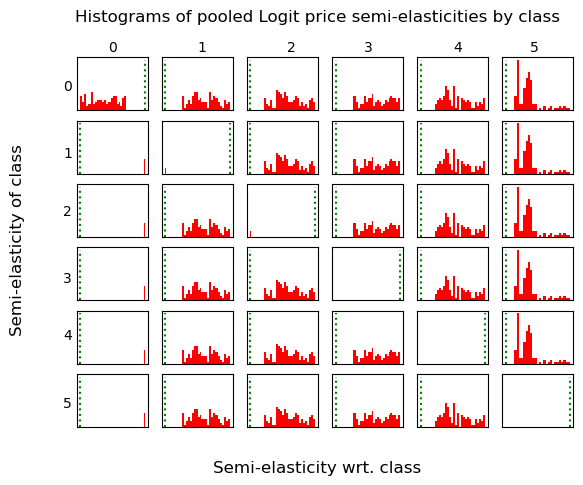

In [81]:
E0p = {j : (E0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(E0p[j], num_bins, range = (np.quantile(E0p[j], 0.10), np.quantile(E0p[j], 0.90)), color = 'r', alpha = 1) # Logit is blue
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Logit price semi-elasticities by class')
fig.supxlabel('Semi-elasticity wrt. class')
fig.supylabel('Semi-elasticity of class')
if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

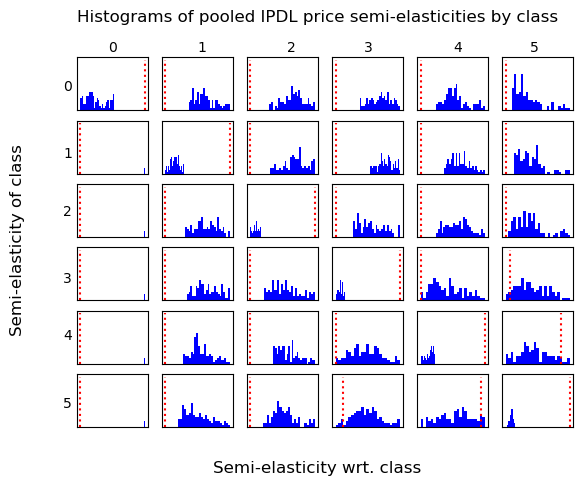

In [82]:
E1p = {j : (E1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(E1p[j], num_bins, range = (np.quantile(E1p[j], 0.10), np.quantile(E1p[j], 0.90)), color = 'b', alpha = 1) # IPDL is blue
    axes[p].vlines(0, 0, 25, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled IPDL price semi-elasticities by class')
fig.supxlabel('Semi-elasticity wrt. class')
fig.supylabel('Semi-elasticity of class')

if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### The mean elasticities for the logit model are given as...

In [83]:
pd.DataFrame(E0.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. class', index = 'Mean elasticity of class')

Mean elasticity wrt. class,0,1,2,3,4,5
Mean elasticity of class,,,,,,
0,-0.003261,0.001052,0.000998,0.000711,0.000311,0.000189
1,0.170102,-0.172311,0.000998,0.000711,0.000311,0.000189
2,0.170102,0.001052,-0.172365,0.000711,0.000311,0.000189
3,0.170102,0.001052,0.000998,-0.172652,0.000311,0.000189
4,0.170102,0.001052,0.000998,0.000711,-0.173053,0.000189
5,0.170102,0.001052,0.000998,0.000711,0.000311,-0.173175


#### For IPDL the mean elasticities are...

In [84]:
pd.DataFrame(E1.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. class', index = 'Mean elasticity of class')

Mean elasticity wrt. class,0,1,2,3,4,5
Mean elasticity of class,,,,,,
0,-0.003563,0.001096,0.001076,0.000811,0.000361,0.000220
1,0.154679,-0.355211,0.076783,0.074719,0.033596,0.015434
2,0.154679,0.082262,-0.315598,0.038811,0.027140,0.012706
3,0.154679,0.105016,0.052393,-0.334010,0.015338,0.006584
4,0.154679,0.107891,0.079243,0.033330,-0.362370,-0.012773
5,0.154679,0.087504,0.070788,0.029351,-0.033131,-0.309191


### Diversion ratios

We now visualize the implied diversion ratios $\mathcal{D}$. If $\bar D_{c\ell}$ denotes the sum of choice probability weigthed diversion ratios, then we have as above that $\bar D_{c\ell} = \sum_{j}\sum_{k} \mathrm{1}_{\{j\in c\}} \mathrm{1}_{\{k\in \ell\}} q_j q_k \mathcal{D}_{jk}$ i.e. more generally $\bar D = (\psi^{\text{class}} \circ q) \mathcal{D} (\psi^{\text{class}} \circ q).'$

In [85]:
def DiversionRatio_agg(data, Theta, q, x, psi, nest_count, direction_var, market_id = 'market', product_id = 'co', char_number = K-1, model = 'IPDL', outside_option = True):
    ''' 
    '''

    dq_du_agg = ccp_directionalgrad(data, Theta, q, x, psi, nest_count, direction_var, market_id, product_id, model, outside_option)[1]
    D_agg = {}

    for t in np.arange(T):
        D_agg[t] = -100*np.einsum('cl,c->cl', dq_du_agg[t], 1./np.diag(dq_du_agg[t]))

    return D_agg

In [86]:
D_IPDLagg = DiversionRatio_agg(dat, ThetaOptBLP, qOpt, z_logit, Psi, Nest_count, 'cla', char_number = pr_index)
D_Logitagg = DiversionRatio_agg(dat, LogitBLP_beta, logit.logit_ccp(LogitBLP_beta, z_logit), z_logit, Psi, Nest_count, 'cla', char_number = pr_index, model = 'Logit')

In [87]:
D0, D1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    D0[t,:,:] = D_Logitagg[t]
    D1[t,:,:] = D_IPDLagg[t]

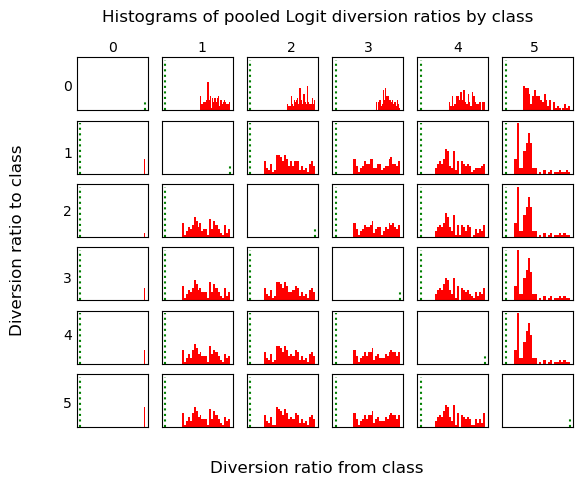

In [88]:
D0p = {j : (D0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D0p[j], num_bins, range = (np.quantile(D0p[j], 0.10), np.quantile(D0p[j], 0.90)), color = 'r', alpha = 1) # Logit is red
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled Logit diversion ratios by class')
fig.supxlabel('Diversion ratio from class')
fig.supylabel('Diversion ratio to class')

if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

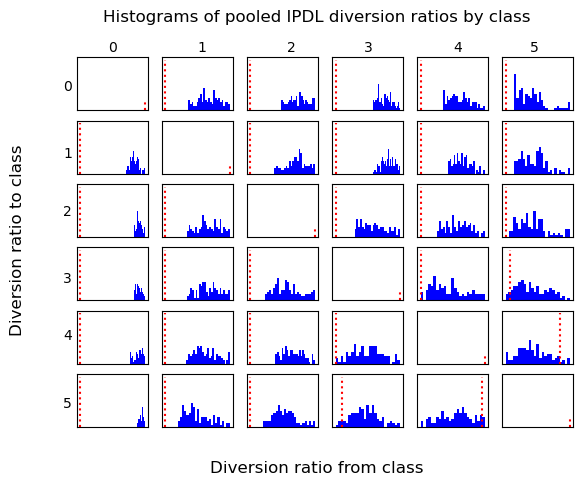

In [89]:
D1p = {j : (D1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg, sharex=False, sharey=False)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D1p[j], num_bins, range = (np.quantile(D1p[j], 0.10), np.quantile(D1p[j], 0.90)), color = 'b', alpha = 1) # IPDL is blue
    axes[p].vlines(0, 0, 25, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of pooled IPDL diversion ratios by class')
fig.supxlabel('Diversion ratio from class')
fig.supylabel('Diversion ratio to class')
if OO:
    fig.text(0.11, 0.82, '0', ha = 'center', va = 'center')
    fig.text(0.11, 0.68, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.56, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.42, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.3, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.18, 0.9, '0', ha = 'center', va = 'center')
    fig.text(0.32, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.46, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.58, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.72, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')
else:
    fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
    fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
    fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
    fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
    fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
    fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
    fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
    fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
    fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
    fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### We also calculate the mean diversion ratios within each class. For the Logit model these are given as...

In [90]:
pd.DataFrame(D0.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. class', index = 'Mean diversion ratio of class')

Mean diversion ratio wrt. class,0,1,2,3,4,5
Mean diversion ratio of class,,,,,,
0,-100.000000,32.977441,30.037606,21.805955,9.610813,5.568185
1,98.716873,-100.000000,0.579788,0.413296,0.180329,0.109713
2,98.685594,0.611145,-100.000000,0.413182,0.180340,0.109739
3,98.522081,0.609950,0.578479,-100.000000,0.179993,0.109496
4,98.294337,0.608266,0.576919,0.411271,-100.000000,0.109208
5,98.225371,0.607820,0.576488,0.410944,0.179377,-100.000000


#### For the IPDL model the mean diversion ratios are...

In [91]:
pd.DataFrame(D1.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. class', index = 'Mean diversion ratio of class')

Mean diversion ratio wrt. class,0,1,2,3,4,5
Mean diversion ratio of class,,,,,,
0,-100.000000,31.645728,29.781028,22.700876,10.083722,5.788647
1,44.323550,-100.000000,21.348908,20.894545,9.237334,4.195663
2,49.273352,25.956544,-100.000000,12.240898,8.558105,3.971100
3,46.540857,31.204486,15.591277,-100.000000,4.657714,2.005667
4,43.108902,29.673367,21.694605,8.969545,-100.000000,-3.446419
5,50.208758,28.195159,22.883511,9.533396,-10.820823,-100.000000


# Conclusion

To conclude we compare parameter estimates from the above models. 

In [130]:
beta_index = pr_index + 1
Logit_nest = ['-' for i in np.arange(G)]
Logitbeta_show = [*(np.round(Logit_beta[:beta_index], decimals = 3).astype('str')), *Logit_nest]
Logitse_show = [*(np.round(Logit_SE[:beta_index], decimals=5).astype('str')), *Logit_nest]
Logitp_show = [*Logit_p[:beta_index], *[1 for i in np.arange(G)]]

pd.DataFrame({
    'Logit_MLE' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip(Logitp_show, Logitbeta_show, Logitse_show)],
    'IPDL_MLE': [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*IPDL_p[:beta_index], *IPDL_p[K:]], [*(np.round(IPDL_theta[:beta_index], decimals = 3).astype('str')), *(np.round(IPDL_theta[K:], decimals = 3).astype('str'))], [*(np.round(IPDL_SE[:beta_index], decimals=5).astype('str')), *(np.round(IPDL_SE[K:], decimals=5).astype('str'))])],
    'FKN' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*FKN_p[:beta_index], *FKN_p[K:]], [*(np.round(FKN_theta[:beta_index], decimals = 3).astype('str')), *(np.round(FKN_theta[K:], decimals = 3).astype('str'))], [*(np.round(FKN_SE[:beta_index], decimals=5).astype('str')), *(np.round(FKN_SE[K:], decimals=5).astype('str'))])],
    'IPDL_BLP' : [par + '***' + ' (' + se + ')' if p < 0.01 else par + '**' + ' (' + se + ')' if p < 0.05 else par + '*' + ' (' + se + ')' if p < 0.1 else par + ' (' + se + ')' for p,par,se in zip([*OptBLP_p[:beta_index], *OptBLP_p[K:]], [*(np.round(ThetaOptBLP[:beta_index], decimals = 3).astype('str')), *(np.round(ThetaOptBLP[K:], decimals = 3).astype('str'))], [*(np.round(SEOptBLP[:beta_index], decimals=5).astype('str')), *(np.round(SEOptBLP[K:], decimals=5).astype('str'))])]
}, 
index = [*x_vars[:beta_index], *['group_' + par for par in nest_vars]])

,Logit_MLE,IPDL_MLE,FKN,IPDL_BLP
in_out,-2.468*** (4e-05),-2.534 (4.42209),-10.048*** (0.00308),-10.137*** (0.02973)
cy,-0.318*** (2e-05),-0.314 (2.85188),-0.922*** (0.0015),-1.21*** (0.01525)
hp,-0.457*** (2e-05),-0.453 (2.66961),-2.809*** (0.00193),-3.558*** (0.01782)
we,-0.948*** (2e-05),-0.939 (2.34671),-0.054*** (0.00137),-0.092*** (0.01693)
le,-1.928*** (3e-05),-1.944 (3.27157),-1.562*** (0.00143),-1.195*** (0.01992)
wi,-2.056*** (3e-05),-2.083 (4.52762),5.531*** (0.00299),5.157*** (0.03083)
he,-2.021*** (3e-05),-2.071 (3.7952),-0.06*** (0.00179),0.135*** (0.02412)
li,-0.715*** (1e-05),-0.739 (1.45557),-0.883*** (0.00103),-0.642*** (0.01044)
sp,-1.373*** (3e-05),-1.382 (3.07874),2.863*** (0.00202),3.848*** (0.02156)
ac,0.01*** (1e-05),-0.052 (1.18038),0.302*** (0.00064),0.445*** (0.00918)
